<p style="align: center;"><img src="https://static.tildacdn.com/tild6636-3531-4239-b465-376364646465/Deep_Learning_School.png" width="400"></p>

# Глубокое обучение. Часть 2
# Домашнее задание по теме "Механизм внимания"

Это домашнее задание проходит в формате peer-review. Это означает, что его будут проверять ваши однокурсники. Поэтому пишите разборчивый код, добавляйте комментарии и пишите выводы после проделанной работы.

В этом задании вы будете решать задачу классификации математических задач по темам (многоклассовая классификация) с помощью Transformer.

В качестве датасета возьмем датасет математических задач по разным темам. Нам необходим следующий файл:

[Файл с классами](https://docs.google.com/spreadsheets/d/1IMRxByfg7gjoZ5i7rxvuNDvSrbdOJOc-/edit?usp=drive_link&ouid=104379615679964018037&rtpof=true&sd=true)

**Hint:** не перезаписывайте модели, которые вы получите на каждом из этапов этого дз. Они ещё понадобятся.

In [ ]:
!pip install transformers datasets accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 36.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.4/297.4 kB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl 

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn, optim

import transformers, datasets

from typing import Union, List

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
np.random.seed(42)
torch.manual_seed(42)

### Задание 1 (2 балла)

Напишите кастомный класс для модели трансформера для задачи классификации, использующей в качествке backbone какую-то из моделей huggingface.

Т.е. конструктор класса должен принимать на вход название модели и подгружать её из huggingface, а затем использовать в качестве backbone (достаточно возможности использовать в качестве backbone те модели, которые упомянуты в последующих пунктах)

In [ ]:
### This is just an interface example. You may change it if you want.

class TransformerClassificationModel(nn.Module):
    def __init__(self, base_transformer_model: Union[str, nn.Module]) -> None:
        super().__init__()
        self._num_of_classes = 7 # всего у нас будет 7 различных тем

        # с помощью transformers инициализируем нашу модель
        self.backbone = transformers.AutoModel.from_pretrained(base_transformer_model)

        # чтобы потом передать вывод модели в линейный слой, берём размер вывода
        pretrained_output_size = self.backbone.config.hidden_size

        # создаём линейный слой для классификации
        self.classifier = nn.Linear(pretrained_output_size, self._num_of_classes)


    def forward(self,
                labels: torch.Tensor,
                input_ids: torch.Tensor,
                attention_mask: torch.Tensor,
                token_type_ids: torch.Tensor):

        # передаём в hf модель входные данные
        outputs = self.backbone(input_ids,
                                attention_mask=attention_mask)

        # забираем выход последнего слоя [batch, seq_len, hidden] и избавляемся от seq_len
        last_outputs = outputs['last_hidden_state'].mean(dim=1)

        logits = self.classifier(last_outputs)
        loss = None

        if labels is not None:
            criterion = nn.CrossEntropyLoss()
            loss = criterion(logits, labels)

        # оборачиваем наш вывод в спец класс
        return transformers.modeling_outputs.SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

In [ ]:
model = TransformerClassificationModel('cointegrated/rubert-tiny2')
print(model)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/693 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/118M [00:00<?, ?B/s]

TransformerClassificationModel(
  (backbone): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(83828, 312, padding_idx=0)
      (position_embeddings): Embedding(2048, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-2): 3 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e

### Задание 2 (1 балл)

Напишите функцию заморозки backbone у модели (если необходимо, возвращайте из функции модель)

In [ ]:
def freeze_backbone_function(model: TransformerClassificationModel) -> TransformerClassificationModel:
    # проходимся по слоям backbone модели и замораживаем их
    for param in model.backbone.parameters():
        param.requires_grad = False

    return model

### Задание 3 (2 балла)

Напишите функцию, которая будет использована для тренировки (дообучения) трансформера (TransformerClassificationModel). Функция должна поддерживать обучение с замороженным и размороженным backbone.

In [ ]:
import copy

def train_transformer(transformer_model: TransformerClassificationModel,
                      model_name: str,
                      freeze_backbone: bool = True) -> TransformerClassificationModel:
    finetunned_model = copy.deepcopy(transformer_model)
    tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)

    # если надо, замораживаем слой
    if freeze_backbone:
        finetunned_model = freeze_backbone_function(finetunned_model)

    def preprocess():
        # считываем данные и кодируем Темы
        df = pd.read_excel('/content/drive/MyDrive/data_problems.xlsx').drop('Unnamed: 0', axis='columns')
        label_map = {topic: i for i, topic in enumerate(df['Тема'].unique().tolist())}
        df['labels'] = df['Тема'].replace(label_map)

        def tokenizer_fn(sentence):
            return tokenizer(sentence['Задача'], padding=True, truncation=True, max_length=512)

        # оборачиваем наши данные в спец класс, токенизируем и забираем нужные нам столбцы
        dataset = datasets.Dataset.from_pandas(df)
        preprocessed = dataset.map(tokenizer_fn, num_proc=4)
        preprocessed = preprocessed.select_columns(['input_ids', 'token_type_ids', 'attention_mask', 'labels'])

        return preprocessed.train_test_split(test_size=0.1)

    dataset = preprocess()

    # задаём аргументы для обучения
    training_args = transformers.Seq2SeqTrainingArguments(
        output_dir="./results",
        evaluation_strategy="epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=4,
        per_device_eval_batch_size=4,
        weight_decay=0.01,
        save_total_limit=1,
        num_train_epochs=5,
    )

    # создаём обучение
    trainer = transformers.Seq2SeqTrainer(
        model=finetunned_model,
        args=training_args,
        train_dataset=dataset["train"],
        eval_dataset=dataset["test"],
        tokenizer=tokenizer,
    )
    trainer.train()

    return finetunned_model

### Задание 4 (1 балл)

Проверьте вашу функцию из предыдущего пункта, дообучив двумя способами
*cointegrated/rubert-tiny2* из huggingface.

In [ ]:
# инициализируем модели и обучаем их
rubert_freezed = TransformerClassificationModel('cointegrated/rubert-tiny2')
rubert_finetuned_freezed = train_transformer(rubert_freezed,
                                             model_name='cointegrated/rubert-tiny2',
                                             freeze_backbone=True)

rubert = TransformerClassificationModel('cointegrated/rubert-tiny2')
rubert_finetuned = train_transformer(rubert,
                                     model_name='cointegrated/rubert-tiny2',
                                     freeze_backbone=False)

/usr/local/lib/python3.10/dist-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Map (num_proc=4):   0%|          | 0/5273 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,1.717700,1.615841
2,1.552200,1.524777
3,1.488900,1.490062
4,1.490000,1.471108
5,1.440100,1.465303


/usr/local/lib/python3.10/dist-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Map (num_proc=4):   0%|          | 0/5273 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,1.098800,1.034895
2,0.954700,0.969218
3,0.822300,0.972255
4,0.777200,0.987886
5,0.716100,0.988323


Модель, которая полностью дообучается, показывает лучшие результаты, так как мы подгоняем все параметры под нашу задачу

### Задание 5 (1 балл)

Обучите *tbs17/MathBert* (с замороженным backbone и без заморозки), проанализируйте результаты. Сравните скоры с первым заданием. Получилось лучше или нет? Почему?

In [14]:
mathbert_freezed = TransformerClassificationModel('tbs17/MathBert')
mathbert_finetuned_freezed = train_transformer(mathbert_freezed,
                                               model_name='tbs17/MathBert',
                                               freeze_backbone=True)

mathbert = TransformerClassificationModel('tbs17/MathBert')
mathbert_finetuned = train_transformer(mathbert,
                                       model_name='tbs17/MathBert',
                                       freeze_backbone=False)

/usr/local/lib/python3.10/dist-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Map (num_proc=4):   0%|          | 0/5273 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,1.552500,1.599515
2,1.524500,1.558652


Epoch,Training Loss,Validation Loss
1,1.552500,1.599515
2,1.524500,1.558652
3,1.479700,1.540517
4,1.471900,1.528262
5,1.477700,1.525227


/usr/local/lib/python3.10/dist-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Map (num_proc=4):   0%|          | 0/5273 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,1.208700,1.161113
2,1.043900,1.087082
3,0.862900,1.115684
4,0.741500,1.272685
5,0.596800,1.346685


Касательн замороженной и не замороженной всё осталось также - полное дообучение модели показывает более хороший результат.

Модель стартовала чуть лучше, однако потом стала переобучаться. Видно, что на тестовой выборке RuBERT получил более низкий loss, однако на обучающей MathBERT показал себя лучше.

Это может быть связано с тем, что эмбединги MathBERT как раз заточены под анализ математических задач.

P.S. У нас 3 прогресс бара обучения, потому что прервалось окружение, не обращайте внимания на первый прогон.

### Задание 6 (1 балл)

Напишите функцию для отрисовки карт внимания первого слоя для моделей из задания

In [47]:
def draw_first_layer_attention_maps(attention_head_ids: List[int],
                                    text: List[str],
                                    model_name: str,
                                    model: TransformerClassificationModel):
    tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)
    input_ids = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512).input_ids
    outputs = model.backbone(input_ids, output_attentions=True)
    attentions = outputs.attentions

    layer_attentions = attentions[0]

    for head_id in attention_head_ids:
        # берём карту для i-ой головы
        attention_head = layer_attentions[0, head_id, :, :]

        # преобразуем в NumPy array
        attention_head_np = attention_head.detach().numpy()

        # берём размер карт внимания
        seq_len = attention_head_np.shape[-1]
        attention_head_2d = attention_head_np.reshape(seq_len, seq_len)

        # нормируем значения в карте
        attention_head_2d = attention_head_2d / attention_head_2d.sum()

        # отрисовываем
        fig, ax = plt.subplots(figsize=(5,5))
        im = ax.imshow(attention_head_2d, cmap='Blues')
        fig.colorbar(im, ax=ax)
        plt.show()

### Задание 7 (1 балл)

Проведите инференс для всех моделей **ДО ДООБУЧЕНИЯ** на 2-3 текстах из датасета. Посмотрите на головы Attention первого слоя в каждой модели на выбранных текстах (отрисуйте их отдельно).

Попробуйте их проинтерпретировать. Какие связи улавливают карты внимания? (если в модели много голов Attention, то проинтерпретируйте наиболее интересные)

RuBERT
_________________________________________


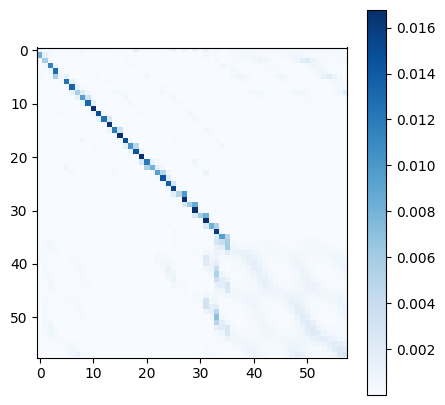

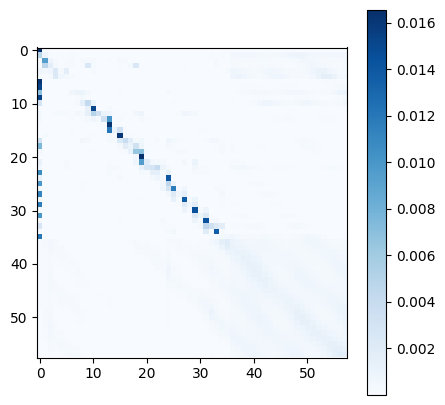

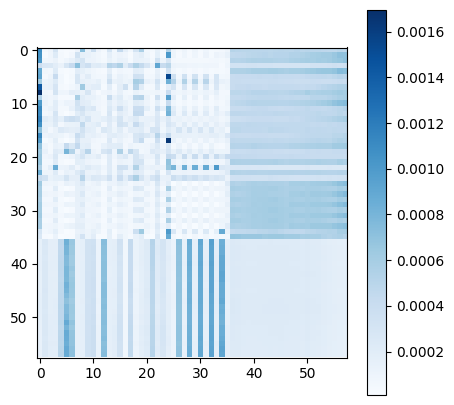



MathBERT
_________________________________________


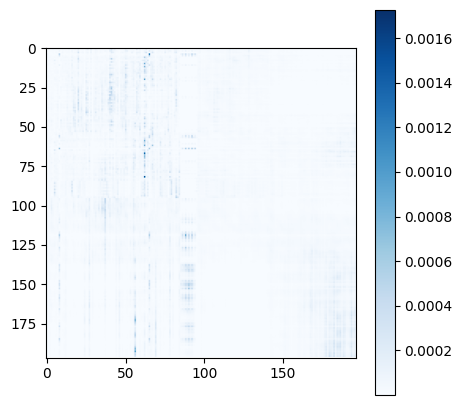

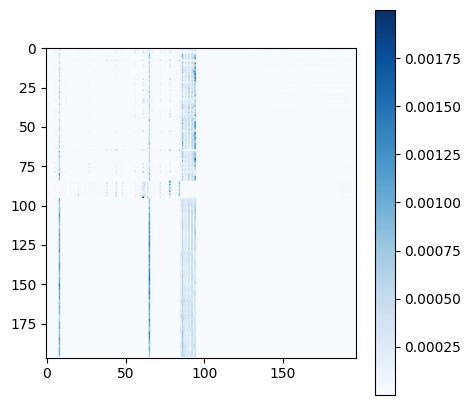

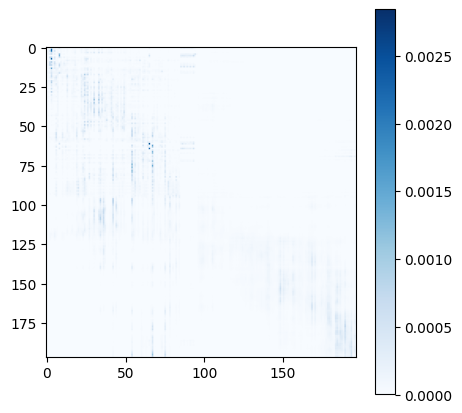

In [54]:
### YOUR CODE IS HERE
texts = ['Докажите, что не существует графа без петель и кратных рёбер с пятью вершинами, степени которых равны 4, 4, 4, 4, 2.',
            'Докажите, что для любого плоского графа (в том числе и несвязного) справедливо неравенство  E ≤ 3V – 6.',
            'На столе лежат несколько тонких спичек одинаковой длины. Всегда ли можно раскрасить их концы  а) в 2,   б) в 3 цвета так, чтобы два конца каждой спички были разных цветов, а каждые два касающихся конца (разных спичек) – одного и того же цвета? ']

print('RuBERT')
print('_________________________________________')
draw_first_layer_attention_maps([0,1,2],
                            texts,
                            # 'Докажите, что не существует графа без петель и кратных рёбер с пятью вершинами, степени которых равны 4, 4, 4, 4, 2.',
                            'cointegrated/rubert-tiny2',
                            rubert_finetuned_freezed.to('cpu'))
print()
print()

print('MathBERT')
print('_________________________________________')
draw_first_layer_attention_maps([0,1,2],
                            texts,
                            # 'Докажите, что не существует графа без петель и кратных рёбер с пятью вершинами, степени которых равны 4, 4, 4, 4, 2.',
                            'tbs17/MathBert',
                            mathbert_finetuned_freezed.to('cpu'))

В качестве моделей возьмём замороженные потому, что части, отвечающие за Attention не изменялись никак, а значит остались такими же, как и у только что инициализированной модели

Отрисуем только 3 первые головы

Итак, головы определяют важность каждого токена к каждому токену. Как мы можем видеть, у MathBERT связи построены не настолько выразительно, как у RuBERT. Это может быть связано с тем, что задачки были сформулированы на русском языке.

Сами связи могут означать вообще разные вещи, так как модели подгоняли их "сами под себя". Связи просто улавливают какой-то вид взаимоотношений между токенами.

### Задание 8 (1 балл)

Сделайте то же самое для дообученных моделей. Изменились ли карты внимания и связи, которые они улавливают? Почему?

RuBERT
_________________________________________


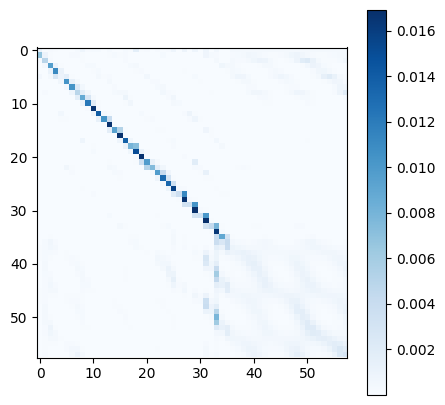

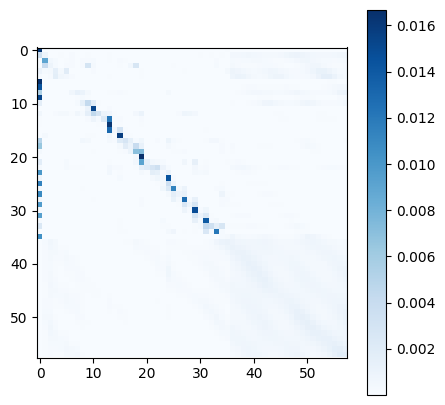

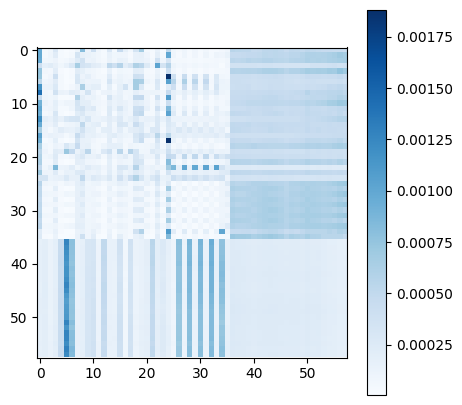



MathBERT
_________________________________________


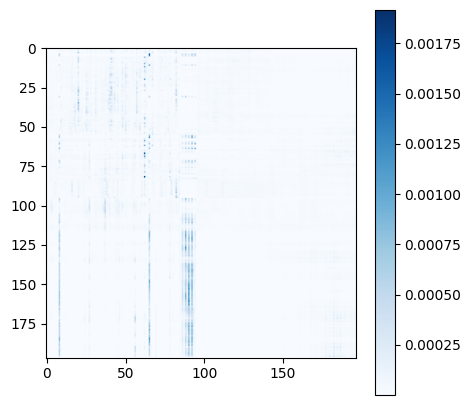

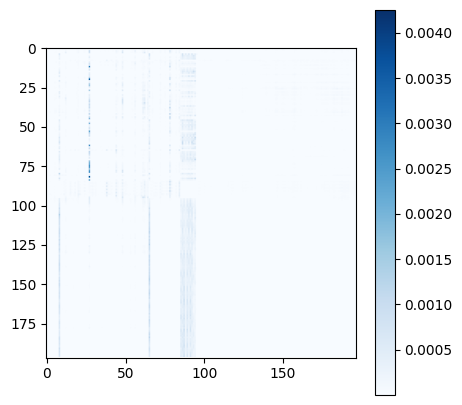

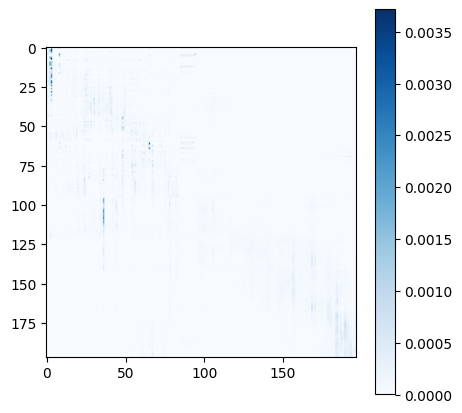

In [55]:
### YOUR CODE IS HERE
texts = ['Докажите, что не существует графа без петель и кратных рёбер с пятью вершинами, степени которых равны 4, 4, 4, 4, 2.',
            'Докажите, что для любого плоского графа (в том числе и несвязного) справедливо неравенство  E ≤ 3V – 6.',
            'На столе лежат несколько тонких спичек одинаковой длины. Всегда ли можно раскрасить их концы  а) в 2,   б) в 3 цвета так, чтобы два конца каждой спички были разных цветов, а каждые два касающихся конца (разных спичек) – одного и того же цвета? ']

print('RuBERT')
print('_________________________________________')
draw_first_layer_attention_maps([0,1,2],
                            texts,
                            # 'Докажите, что не существует графа без петель и кратных рёбер с пятью вершинами, степени которых равны 4, 4, 4, 4, 2.',
                            'cointegrated/rubert-tiny2',
                            rubert_finetuned.to('cpu'))
print()
print()

print('MathBERT')
print('_________________________________________')
draw_first_layer_attention_maps([0,1,2],
                            texts,
                            # 'Докажите, что не существует графа без петель и кратных рёбер с пятью вершинами, степени которых равны 4, 4, 4, 4, 2.',
                            'tbs17/MathBert',
                            mathbert_finetuned.to('cpu'))

В наших моделях присутствуют совсем небольшие изменения (первые графики MathBERT точно), они связаны с тем, что мы подгоняем механизм внимания под нашу конкретную задачу, однако эти изменения на графиках пока не так отчетливо выражены